## Dependencies

In [217]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt
import openpyxl

In [218]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

start = '2018-01-01 00:00:00'
end = '2019-12-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.03)


## Solving forward

In [219]:
## Contstraints and constants

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 30, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3}, 
             'states': {100: 1, 75: 0.75, 50: 0.5, 25: 0.25, 0:0 }}

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j):
    return model.v0[i]

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow

inflow_hydro1_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}
inflow_hydro2_scale = {'High': 1.5, 'Avg': 1, 'Low': 0.5}

def inflow1_scenario(model, i, j):
    scenario_value = model.scenario.value
    if i == 'Hydro1':
        return model.inflow[i, j] == inflow_hydro1_scale[scenario_value] * inflow_hydro1[j]
    elif i == 'Hydro2':
        return model.inflow[i, j] == inflow_hydro2_scale[scenario_value] * inflow_hydro2[j]
# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.m['Buy',j] == model.L[j] - (model.r[j])

def power_rule(model,i, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j] == model.p[i, j]#MW

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods)] >= model.v0[i] - tolerance

fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
    
def volume_change_rule(model, i, j):  
    if j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) - (model.s[i,j]*fm3)
    else: 
        if i =='Hydro1': 
            return model.v[i, j ] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) +(model.pump['Hydro2',j]*fm3) - (model.s[i,j]*fm3)
        elif i =='Hydro2':
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow[i,j]*fm3) -(model.s[i,j]*fm3)   

### Handling future cost

In [220]:
# Read water values and make them readable
fc = pd.read_csv('data/Future_cost.csv', index_col=0)
#display(fc)
#fc.plot()

# Define a function to convert string labels back to tuples
def label_parser(label):
    parts = label.strip('()').split(', ')
    return (int(parts[0]), int(parts[1]))

# Convert the MultiIndex labels to tuples for indexing
fc.index = fc.index.map(label_parser)
fc.columns = fc.columns.astype(int)
#map so that stage in stages call on the string name of the column in the dataframe when solving later
#column_mapping = {i: f'Stage {i}' for i in range(1, 51)}   #this is needed because the column names are not integers, but strings      
# Access a specific value using a tuple as the row label
value = fc.loc[(0, 0), 1]
stage1 = fc[1].to_dict()#.reset_index(drop=True)


In [221]:
def solve_first_stage(constants, topology, stage, alpha_values, dual1, dual2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24 + 1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart']) 
    print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    #print("This is volume", max(model.v))
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    #model.alpha_cons = pyo.Constraint(rule=create_alpha)
    model.alpha_cons = pyo.ConstraintList()   
    
    # List to store expected cost from next stage
    phi_values = []
    
    #List to store dual value of reservoir 1 & 2 in next stage
    lambda1_values = []
    lambda2_values = []

    #List to store initial volumes introduced in states
    Hydro1_volume=[]
    Hydro2_volume=[]

    #Appending values from next stage 
    for key in alpha_values:
        Hydro1_volume.append(key[0])
        Hydro2_volume.append(key[1])
        phi_values.append(alpha_values[key])
        lambda1_values.append(dual1[1])
        lambda2_values.append(dual2[1])
    
    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= phi_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i])))
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_first, sense=pyo.minimize)
    return model


#model.probs 
#Solving functions:
def OBJ_first(model):
    return sum((model.r[j] * model.Ri + model.Mi[j] * model.m['Buy', j]) for j in model.periods) + model.alpha  #should model.probs be included?

def OBJ_forward(model):
    return sum((model.r[j] * model.Ri + model.Mi[j] * model.m['Buy', j]) for j in model.periods) + model.alpha


#def create_alpha(model):
#    return model.alpha >= model.phi + model.lambda1*(model.v['Hydro1',max(model.periods)] - model.v0['Hydro1']) + model.lambda2*(model.v['Hydro2',max(model.periods)] - model.v0['Hydro2'])

#in create alph,a lambda is multiplied with x_now - x_ref
#Alpha is the approximation of the future cost for week 2, which is limited by cuts (one cut for all of the 25 discretisation you calculated in the backward iteration).


def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=True)             
    return results, model

def displayresults(model):
    print(model.dual.display())

In [222]:
def solve_forward(constants, topology, stage, start_vol, alpha_values, dual1, dual2, scenario):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="Solve Forward")

    # Define the inflow scenarios and associated probabilities

    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range((stage-1)*7*24+1, (stage)*7*24+1, 1))
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])      
    model.market = pyo.Set(initialize=['Buy','Sell'])

    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])
 
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize={'Hydro1': start_vol[0], 'Hydro2': start_vol[1]}) 
    #print('This is start volume:', model.v0['Hydro1'], model.v0['Hydro2'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])

    #Scenario parameter
    model.probs=pyo.Param(initialize=constants['inflow_probabilities'][scenario])
    model.scenario = pyo.Param(initialize=scenario)

    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods,  within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods, bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods, within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods, bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods, within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods, bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods, within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods, bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.alpha = pyo.Var() #within=NonNegativeReals, 
    
    #--- CONSTRAINTS---
    model.inflow_cons=pyo.Constraint(model.plants,  model.periods, rule=inflow1_scenario)
    model.load_cons = pyo.Constraint( model.periods, rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods, rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods, rule=volume_change_rule) 
    model.alpha_cons = pyo.ConstraintList()                              #Not really necessary since it's only adding one constraint that resets for every stage buy hey if it works it works
    
    # List to store expected cost from next stage
    phi_values = []
    
    #List to store dual value of reservoir 1 & 2 in next stage
    lambda1_values = []
    lambda2_values = []

    #List to store initial volumes introduced in states
    Hydro1_volume=[]
    Hydro2_volume=[]

    #Appending values from next stage 
    for key in alpha_values:
        Hydro1_volume.append(key[0])
        Hydro2_volume.append(key[1])
        phi_values.append(alpha_values[key])        #Correct to assume that phi = alpha from next?
        lambda1_values.append(dual1[1])
        lambda2_values.append(dual2[1])
    
    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi - lambda1*(x1-x1_hat) - lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(fc.index)):
        model.alpha_cons.add(model.alpha >= phi_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] - (Hydro1_volume[i])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (Hydro2_volume[i])))
    
    #INCORPORATE fc dataframe more here maybe to create cuts over the state combination future costs
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_forward, sense=pyo.minimize)       #model.alpha is called here and should already be defined by the constraints or variable
        
    
    return model

In [223]:
stage = 2
alpha_values = fc[stage].to_dict()

# List to store expected cost from previous stage
phi_values = []
    
#List to store dual value of reservoir 1 & 2 in previous stage
lambda1_values = []
lambda2_values = []

#List to store initial volumes introduced in states
state_volumes=[]

dual1 = {}
dual2 = {}
dual1[stage] = 0
dual2[stage] = 0
#List to store initial volumes introduced in states
Hydro1_volume=[]
Hydro2_volume=[]

#Appending values from next stage 
for key in alpha_values:
    Hydro1_volume.append(key[0])
    Hydro2_volume.append(key[1])
    phi_values.append(alpha_values[key])
    lambda1_values.append(dual1[stage])
    lambda2_values.append(dual2[stage])


In [224]:
## Solving forward loop for each stage after first stage
    # Solve individually for each stage and obtain the model.v values at the end of each stage
stages=range(1, 50 + 1, 1)
scenarios= ['High','Avg', 'Low'] #
scenario_data = {}

Dual_values1={}
Dual_values2={}
alpha_values_list = []
hydro1_water_val = []
hydro2_water_val = []   
objective_values = []

constants['inflow_probabilities'] 

for s in scenarios:
    end_volume = {}
    print(' ')
    print('Solving for scenario', s)
    print(' ')
    alpha_values_scenario = []
    objective_values_scenario = []
    for stage in stages:
        if stage == 1:
            alpha_values = fc[stage+1].to_dict()        #Future cost in next stage, no future costs for stage 1 except one expected cost
            Dual_values1[stage] = -29000                #Changing the dual_values dramatically changes how the water reservoris are emptied
            Dual_values2[stage] = -25000
            print(' ')
            print('Week: ', stage)
            model = solve_first_stage(constants, topology, stage, alpha_values, Dual_values1, Dual_values2, s) 
            solve(model)
            expected = model.obj()
            objective_values.append(expected)
            objective_values_scenario.append(expected)

            stage_results = ()                                                                                   # Tuple to store volume results for each stage
            for i in model.plants:
                reservoir_v = model.v[i, max(model.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                    #this is the new initial volume for the next stage
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)
            print("This is the alpha value:",model.alpha.value)
            
            alpha_values_list.append(model.alpha.value)
            alpha_values_scenario.append(model.alpha.value)

            Dual_values1[stage]= model.dual.get((model.volume_change_cons['Hydro1', max(model.periods)])) 
            Dual_values2[stage]= model.dual.get((model.volume_change_cons['Hydro2', max(model.periods)])) 
            hydro1_water_val.append(Dual_values1[stage])
        else:
            alpha_values = fc[stage+1].to_dict()
            print(' ')
            print('Week: ', stage)
            model_forward = solve_forward(constants, topology, stage, start_vol, alpha_values, Dual_values1, Dual_values2, s) #start_vol is the X_hat
            print("Start volume of stage ", stage, " is: ", model_forward.v0['Hydro1'], model_forward.v0['Hydro2'])
            solve(model_forward)
            expected = model_forward.obj() 
            objective_values.append(expected)
            objective_values_scenario.append(expected)

            stage_results = ()  
            for i in model_forward.plants:
                reservoir_v = model_forward.v[i, max(model_forward.periods)].value
                stage_results += (reservoir_v,)
            end_volume[stage] = stage_results                                                                         #this is the new initial volume for the next stage
            print("End volume of stage ", stage, " is: ", end_volume)
            start_vol = end_volume[stage]                                                                        #initializing this to be the new initial volume for the next stage (X_hat)
            print("This is the alpha value:",model_forward.alpha.value)
            
            alpha_values_list.append(model_forward.alpha.value)
            alpha_values_scenario.append(model_forward.alpha.value)

            Dual_values1[stage]= model_forward.dual.get((model_forward.volume_change_cons['Hydro1', max(model_forward.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
            Dual_values2[stage]= model_forward.dual.get((model_forward.volume_change_cons['Hydro2', max(model_forward.periods)])) #+ model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Avg'])) + model.dual.get((model.volume_change_cons['Hydro1', max(model.periods), 'Low'])))/len(model.scenarios)
    
    scenario_data[s] = {
        "alpha_values": alpha_values_scenario,
        "objective_values": objective_values_scenario,
    }


    print(Dual_values1)
    print(Dual_values2) 

    

 
Solving for scenario High
 
 
Week:  1
This is start volume: 45.0 20.0
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 5600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1212 rows, 2857 columns and 3632 nonzeros
Model fingerprint: 0xdf6a16eb
Coefficient statistics:
  Matrix range     [4e-03, 3e+04]
  Objective range  [1e+00, 4e+01]
  Bounds range     [2e+00, 5e+01]
  RHS range        [1e-02, 2e+07]
Presolve removed 911 rows and 1926 columns
Presolve time: 0.01s
Presolved: 301 rows, 931 columns, 1230 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7814327e+07   6.145939e+00   0.000000e+00      0s
     379    1.8082496e+07   0.000000e+00   0.000000e+00      0s

Solved in 379 iterations and 0.03 seconds (0.01 work units)
Optimal objective  1.808249582e+07
This is the alpha v

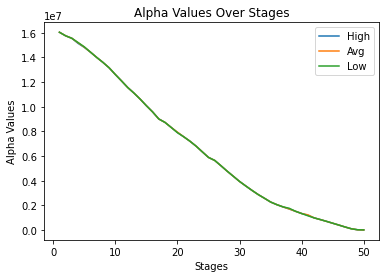

In [225]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in scenarios:
    alpha_values_scenario = scenario_data[s]["alpha_values"]
    x_values = range(1, len(alpha_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, alpha_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Alpha Values')
ax.set_title('Alpha Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()


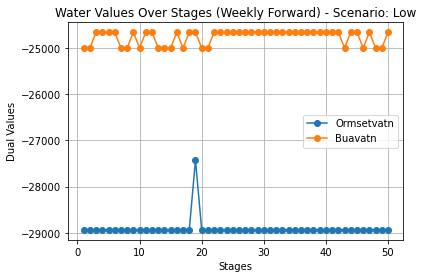

In [226]:
# Extract the keys (stages) and values from the dictionaries
stages = list(Dual_values1.keys())
values1 = list(Dual_values1.values())
values2 = list(Dual_values2.values())

# Create a line plot for Dual_values1
plt.plot(stages, values1, label='Ormsetvatn', marker='o', linestyle='-')

# Create a line plot for Dual_values2
plt.plot(stages, values2, label='Buavatn', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Stages')
plt.ylabel('Dual Values')
plt.title('Water Values Over Stages (Weekly Forward) - Scenario: Low')

# Add a legend to differentiate between Dual_values1 and Dual_values2
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

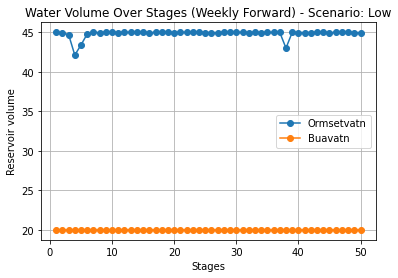

In [227]:
# Extract the keys (stages) and values from the dictionaries
stages = list(end_volume.keys())
values1 = [item[0] for item in end_volume.values()]
values2 = [item[1] for item in end_volume.values()]

plt.plot(stages, values1, label='Ormsetvatn', marker='o', linestyle='-')
plt.plot(stages, values2, label='Buavatn', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Stages')
plt.ylabel('Reservoir volume')
plt.title('Water Volume Over Stages (Weekly Forward) - Scenario: Low')

# Add a legend to differentiate between Dual_values1 and Dual_values2
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [228]:
print(scenario_data[s]["objective_values"])

[18120124.646604963, 17863797.293966513, 17684685.41039729, 17263299.762294896, 17057193.65678637, 16662599.19453609, 16173701.191556783, 15753874.189346628, 15255921.913541293, 14612507.959363487, 14052408.617504992, 13531210.996894907, 12892542.428360661, 12455063.217948357, 11941461.166098082, 11270294.130430367, 10673728.551589085, 10320628.578581218, 9506948.243757203, 9338660.450697847, 9085278.127376182, 8744881.708380518, 8309265.150955493, 7871746.253622411, 7362807.559493367, 7147578.476028368, 6682583.18018969, 6224530.7258355785, 5770358.346718772, 5345193.134494569, 4993011.664869708, 4645966.505906347, 4365313.618176375, 4084364.2727638287, 3827608.116530233, 3605884.7638969487, 3410296.286675219, 3185239.9261775063, 3063863.583890032, 3042746.293070103, 2779372.1829027752, 2755696.9072338836, 2701053.5760233663, 2654964.8067116993, 2514353.351082282, 2419593.062184085, 2316193.2277427283, 2233835.165905716, 2144953.5891827736, 2155200.610025843]


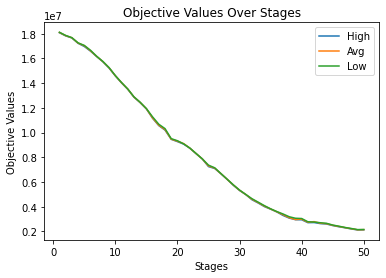

In [229]:
import matplotlib.pyplot as plt

# Create a figure and axis for the plot
fig, ax = plt.subplots()

for s in scenarios:
    objective_values_scenario = scenario_data[s]["objective_values"]
    x_values = range(1, len(objective_values_scenario) + 1)  # X-axis values representing stages
    ax.plot(x_values, objective_values_scenario, label=s)

# Set labels and title
ax.set_xlabel('Stages')
ax.set_ylabel('Objective Values')
ax.set_title('Objective Values Over Stages')

# Add a legend to distinguish between scenarios
ax.legend()

# Show the plot
plt.show()